# Assignment 1 Part A
Part A involved the processing of data from Jane Austen novels and generating word embeddings from them. 

In [1]:
from nltk.corpus import gutenberg
import pandas as pd
from nltk.corpus import stopwords
import string
import re
from keras.preprocessing.sequence import skipgrams
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/leem/anaconda3/envs/eenlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


# Preprocessing the training corpus
In this section I took the Austen text and removed stop words, non-alphanumeric words, spaces and blank words. It also removes sentences shorter than 2 words as the context for a word can't be found if there are no other words in the sentence.

In [2]:
def strip(line, stop_words):
    # Takes in a list of words and nltk stop words.
    strippedLine = []
    for word in line:
        strippedWord = word.lower()
        # Only appends words to strippedLine if not in stop words, not blank, not punctuation and is alphanumeric
        if strippedWord.isdigit() or strippedWord in stop_words or strippedWord == '' or strippedWord == ' ' or strippedWord in string.punctuation or not strippedWord.isalnum():
            continue
        strippedLine.append(strippedWord)
    return strippedLine

In [3]:
# Load austen text in 
austen = gutenberg.sents('austen-sense.txt') + gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt')
print(f"Length of austen should be 16498: {len(austen)}")
stop_words = stopwords.words('english')
newAusten = []

# For each line in austen perform the word strip
for line in austen:
    strippedLine = strip(line,stop_words)
    # If word is shorter than 2 words, skip it. 
    if len(strippedLine) > 2:
        newAusten.append(strippedLine)



Length of austen should be 16498: 16498


## Sanity check for Part A Q1:
My preprocessing has cut 4 more sentences, which should not make a significant difference and the processed line also passes the sanity check. 

In [4]:
print(f"Length of New Austen should be around 13927: {len(newAusten)}") 
print('Processed line:', newAusten[10])

Length of New Austen should be around 13927: 13923
Processed line: ['therefore', 'succession', 'norland', 'estate', 'really', 'important', 'sisters', 'fortune', 'independent', 'might', 'arise', 'father', 'inheriting', 'property', 'could', 'small']


# Creating the corpus vocabulary and preparing the dataset
In this section we created a mapping from word to number and back and used this mapping to convert all the sequences of words into sequences of numbers.

In [5]:
# create index-word relationship
word2idx = {'<PADDINGTOKEN>': 0}
idx2word = {0:'<PADDINGTOKEN>'}
sents_as_ids = []

# For each line in preprocessed text
for line in newAusten:
    sentId = []
    # For each word in line, iif we have seen it before then add the id to the id sentence
    for word in line:
        if word in word2idx:
            sentId.append(word2idx[word])
            continue
        # If we haven't seen the word  before then we need to assign it an id and add that to dictionaries
        count = len(word2idx)
        word2idx[word] = count
        idx2word[count] = word
        sentId.append(count)
    sents_as_ids.append(sentId)
    
# Set vocab size and embed size
vocab_size = len(word2idx)
embed_size = 100

## Sanity check for Part A Q2:

In [6]:
print(vocab_size)
print('\nSample word2idx: ', list(word2idx.items())[:10])
print('\nSample idx2word:', list(idx2word.items())[:10])
print('\nSample normalized corpus:', newAusten[:3])
print('\nAbove sentences as a list of ids:' , sents_as_ids[:3])

10093

Sample word2idx:  [('<PADDINGTOKEN>', 0), ('sense', 1), ('sensibility', 2), ('jane', 3), ('austen', 4), ('family', 5), ('dashwood', 6), ('long', 7), ('settled', 8), ('sussex', 9)]

Sample idx2word: [(0, '<PADDINGTOKEN>'), (1, 'sense'), (2, 'sensibility'), (3, 'jane'), (4, 'austen'), (5, 'family'), (6, 'dashwood'), (7, 'long'), (8, 'settled'), (9, 'sussex')]

Sample normalized corpus: [['sense', 'sensibility', 'jane', 'austen'], ['family', 'dashwood', 'long', 'settled', 'sussex'], ['estate', 'large', 'residence', 'norland', 'park', 'centre', 'property', 'many', 'generations', 'lived', 'respectable', 'manner', 'engage', 'general', 'good', 'opinion', 'surrounding', 'acquaintance']]

Above sentences as a list of ids: [[1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]]


# Generating training instances

In [7]:
skip_grams = [skipgrams(sent, vocabulary_size=vocab_size, window_size=5) for sent in
sents_as_ids]

In [8]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]
# This shows whether the two words occur together in the context window(size of which is set above) 
# 1 if they co-occur 0 
# We get all the times that a word occurs from the first sentence co-occurs with something 
# and only a handful (negative sampling) of the words it does not co-occur with 
for i in range(len(pairs)):
    print('({:s} ({:d}), {:s}, ({:d})) -> {:d}'.format(idx2word[pairs[i][0]], pairs[i][0],idx2word[pairs[i][1]], pairs[i][1],labels[i]))

(sensibility (2), influence, (2010)) -> 0
(austen (4), replacing, (6762)) -> 0
(austen (4), dispersed, (2964)) -> 0
(austen (4), possesses, (3140)) -> 0
(sense (1), much, (135)) -> 0
(sensibility (2), sense, (1)) -> 1
(sense (1), sensibility, (2)) -> 1
(sense (1), austen, (4)) -> 1
(jane (3), lowness, (3863)) -> 0
(sensibility (2), austen, (4)) -> 1
(sensibility (2), stayed, (4461)) -> 0
(jane (3), retrenchment, (8909)) -> 0
(austen (4), sensibility, (2)) -> 1
(austen (4), jane, (3)) -> 1
(sense (1), jane, (3)) -> 1
(sense (1), strawberries, (8268)) -> 0
(jane (3), sense, (1)) -> 1
(sensibility (2), jane, (3)) -> 1
(jane (3), austen, (4)) -> 1
(sensibility (2), impolite, (7865)) -> 0
(jane (3), sensibility, (2)) -> 1
(sense (1), foregoing, (5542)) -> 0
(jane (3), moss, (3131)) -> 0
(austen (4), sense, (1)) -> 1


# Building the Skip-gram Neural Network Architecture
In this section we take the sentences that have been converted into sequences of numbers and train an NN to produce embeddings for these words. 

In [9]:
# Building our own skipgram Neural Network
# This will  predict whether the target word and the context word are co-occuring

# First we build the input pipeline for the target word

# Set the input
target_word = Input((1,), dtype='int32')

# Keras takes all the words in the vocabulary and gives them a unique vector
# we therefore have to give it the dimensionality of the vector we want it to use 
# and tell it how many words it needs to give unique vectors to. 
# The glorot uniform initialises the vector randomly but uniquely
target_embedding = Embedding(vocab_size, embed_size, name='target_embed_layer', \
embeddings_initializer='glorot_uniform', \
input_length=1)(target_word)
# Output of this is weird: a list of 100 sublists, each sublist of length 1
# This reshape changes it into a single list of length 100
target_input = Reshape((embed_size, ))(target_embedding)

# repeat the same for the context word
context_word = Input((1,), dtype='int32')
context_embedding = Embedding(vocab_size, embed_size, name='context_embed_layer', \
embeddings_initializer='glorot_uniform', \
input_length=1)(context_word)
context_input = Reshape((embed_size, ))(context_embedding)

# We merge the inputs and perform a dot product on them
# The similarity of the two vectors is given by this dot product
merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])

# Single sigmoid converts the similarity into a 1 or a 0
label = Dense(1,activation='sigmoid')(merged_inputs)
model = Model(inputs=[target_word, context_word], outputs=[label])
model.compile(loss='mean_squared_error', optimizer='rmsprop')

# Later we will train this model by having it predict the answers from the cell above. 
# This training will result in tweaks to the weights for the vectors, 
# which is what we will use as the vector for the given word


## Part A Q3 Sanity Check:

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
target_embed_layer (Embedding)  (None, 1, 100)       1009300     input_1[0][0]                    
__________________________________________________________________________________________________
context_embed_layer (Embedding) (None, 1, 100)       1009300     input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 

In [11]:
plot_model(model, to_file='skipgram_keras', show_shapes=True, show_layer_names=True,
rankdir='TB')

In [12]:
for epoch in range(1, 6):
    epoch_loss = 0
    # in each epoch, train all the sentences, one per iteration=> batch_size = num_sents
    for i, sent_examples in enumerate(skip_grams):
        target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
        context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
        labels = np.array(sent_examples[1], dtype='int32')
        X = [target_wds, context_wds]
        Y = labels
        if i % 5000 == 0: # after 5000 sentences i.e. 5000 iterations
            print('Processed %d sentences' %i)
        epoch_loss += model.train_on_batch(X, Y)
    print('Processed all %d sentences' %i)
    print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 1 Loss: 2443.424441647716 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 2 Loss: 1976.6649280525744 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 3 Loss: 1889.210235319566 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 4 Loss: 1844.923446359462 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 5 Loss: 1824.12899619143 



# Answers to Part A Q4:
### What would the inputs and outputs to the model be?
The inputs would be vectors of dimension equal to the vocab size. In the case of McCormick's tutorial that's a 1000 dimension vector. The vector is a one-hot encoding of the word. The dimension corresponding to the word it's encoding = 1 and all others = 0. 
The output of the model = number of neurons in output layer, which in the tutorial is 300. This therefore outputs a 300 dimension vector, which is the skipgram representation of the original word. 
### How would you use the Keras framework to create this architecture?
In the below keras code, i create one layer to do the onehot encoding first and then the 300 neuron hidden layer. Alternatively you could handle the onehot encoding differently by first onehot encoding the data, removing the need for a onehot layer. Softmax is used as the activation function for the 300 dim input layer as we want values of the vector dimensions to be bound. 
- model = Sequential()
- model.add(OneHot(VOCAB_SIZE,1))
- model.add(Dense(300, activation='softmax))
###  Can you think of reasons why this model is considered to be inefficient?
It takes in an extremely sparse vector as an input, which means its a large vector without much information. This results in a model with 2million parameters.  It's easier for us to generate random 300 dimension vectors for each word to begin with and then have the model optimise this as this uses fewer parameters. 

# Part A Q5: 

In [36]:
# Get the word embeddings by getting the weights of the embed layer
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0]

In [41]:
# Show the embeddings 
print(word_embeddings.shape)
print(pd.DataFrame(word_embeddings, index=idx2word.values()).head(10))

(10093, 100)
                      0         1         2         3         4         5   \
<PADDINGTOKEN> -0.012631  0.002863  0.000215  0.010280  0.000045 -0.016784   
sense          -0.000619  0.038049 -0.005977  0.025992 -0.042562 -0.007328   
sensibility    -0.029605  0.023099  0.028955 -0.016231  0.013143  0.012611   
jane            0.089862 -0.060235 -0.002126 -0.040743  0.026437  0.048125   
austen         -0.030632  0.029559 -0.013486 -0.004962  0.011429 -0.016096   
family          0.054916  0.011609 -0.059308 -0.043058 -0.053189 -0.017252   
dashwood       -0.119744  0.057427  0.050500  0.127728 -0.035849 -0.058869   
long            0.030773 -0.065037  0.051264 -0.077794 -0.011770  0.066154   
settled         0.006896  0.000058  0.022398  0.019979  0.015494  0.004329   
sussex          0.001971  0.022248  0.012762  0.001522  0.009328 -0.001340   

                      6         7         8         9     ...           90  \
<PADDINGTOKEN>  0.008239 -0.010170 -0.006967  0.00

In [38]:
# Find the similarity of evey word with every other word by doing dot product. 
similarity_matrix = cosine_similarity(word_embeddings)
print(similarity_matrix.shape)

(10093, 10093)


In [39]:
# Set some particular words to compare
search_terms = ['man', 'miss', 'sister', 'woman', 'lady', 'kindness', 'god', 'man', 'folly', 'fool']
# Find the closest 5 words to each search word
similar_words = {term: [idx2word[idx] \
for idx in (-1 * similarity_matrix[word2idx[term]-1]).argsort()[1:6] + 1] \
for term in search_terms}

for word in similar_words.keys():
    print(word,similar_words[word])

man ['meets', 'willoughbys', 'disgusting', 'grandmamma', 'intimated']
miss ['guests', 'satisfaction', 'celebrated', 'declarations', 'fainter']
sister ['wording', 'risen', 'friendliness', 'overpower', 'greatcoat']
woman ['rapturously', 'variations', 'struggle', 'swoon', 'accounted']
lady ['arise', 'temper', 'specious', 'introduced', 'baronight']
kindness ['chaperon', 'refreshed', 'cheeks', 'detached', 'captivating']
god ['original', 'presence', 'stanza', 'emulate', 'hatred']
folly ['band', 'committed', 'fairfax', 'satisfactory', 'accomplish']
fool ['handed', 'leg', 'provide', 'hazle', 'appeal']


# Part A Q6: Visualising the word embeddings

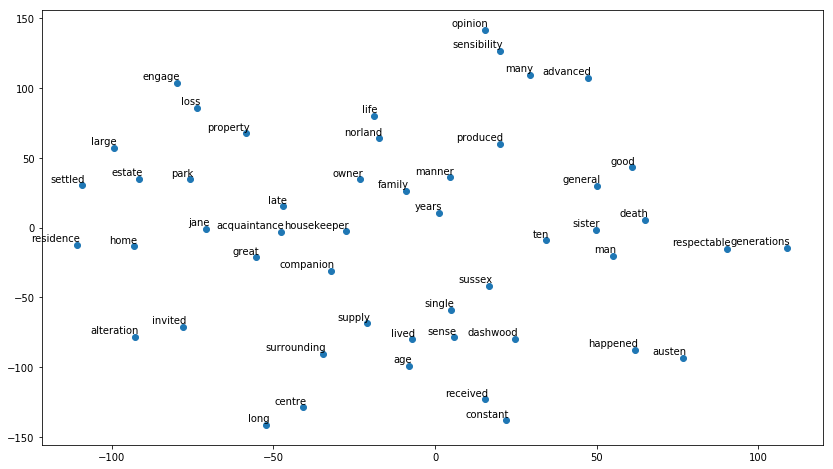

In [40]:
# Reduce dimensionality down to 2 dimensions so our puny human minds can comprehend it
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50

# Perform dim reduction on first 50 only
T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right',va='bottom')